In [1]:
%load_ext memory_profiler
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from dask.distributed import Client, LocalCluster, wait
from itertools import chain
from pathlib import Path
from glob import glob
import xarray as xr

In [4]:
from xorca.lib import load_xorca_dataset
from xorca.calc import calculate_speed, calculate_psi, calculate_moc

In [5]:
# Start a local cluster with 8 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 750 MiB of memory each.
cluster = LocalCluster(n_workers=8, threads_per_worker=1, memory_limit=750e6,
                       silence_logs=50)
client = Client(address=cluster)

In [6]:
client

Client Scheduler: tcp://127.0.0.1:44129 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 6.00 GB


In [7]:
data_path = Path("../../xorca-example-data/ORCA05.L46-KKG36F25H/")
data_files = list(sorted(data_path.glob("ORCA05*nc")))
# data_files.append(data_path / "new_maskglo.nc")
aux_files = list(sorted(data_path.glob("[m, n]*nc")))

In [8]:
print(aux_files)
print(data_files)

[PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/mesh_mask.nc'), PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/new_maskglo.nc')]
[PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20080101_20081231_grid_T.nc'), PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20080101_20081231_grid_U.nc'), PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20080101_20081231_grid_V.nc'), PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20080101_20081231_icemod.nc'), PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20090101_20091231_grid_T.nc'), PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20090101_20091231_grid_U.nc'), PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20090101_20091231_grid_V.nc'), PosixPath('../../xorca-example-data/ORCA05.L46-KKG36F25H/ORCA05.L4

In [9]:
%%time
%%memit
ds_xorca = load_xorca_dataset(data_files=data_files, aux_files=aux_files,
                              decode_cf=True,
                              input_ds_chunks={"time_counter": 1, "t": 1,
                                               "z": 6, "Z": 6,
                                               "deptht": 6, "depthu": 6,
                                               "depthv": 6, "depthw": 6,
                                               "y": 256, "Y": 256,
                                               "x": 361, "X": 361},
                              target_ds_chunks={"t": 1,
                                                "z_c": 6, "z_l": 6,
                                                "y_c": 256, "y_r": 256,
                                                "x_c": 361, "x_r": 361})

peak memory: 250.77 MiB, increment: 132.30 MiB
CPU times: user 6.67 s, sys: 489 ms, total: 7.16 s
Wall time: 14.8 s


In [10]:
print(ds_xorca)
print(ds_xorca.nbytes / 1e9, "GiB")

<xarray.Dataset>
Dimensions:   (t: 33, x_c: 720, x_r: 720, y_c: 509, y_r: 509, z_c: 46, z_l: 46)
Coordinates:
  * t         (t) datetime64[ns] 2008-01-16T12:00:00 2008-02-15 ...
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
    depth_c   (z_c) float64 dask.array<shape=(46,), chunksize=(6,)>
    depth_l   (z_l) float64 dask.array<shape=(46,), chunksize=(6,)>
    llat_cc   (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(256, 361)>
    llat_cr   (y_c, x_r) float32 dask.array<shape=(509, 720), chunksize=(256, 361)>
    llat_rc   (y_r, x_c) float32 dask.arra

In [11]:
%%time
%memit psi_mean = calculate_psi(ds_xorca).mean("t").compute()

peak memory: 358.61 MiB, increment: 107.64 MiB
CPU times: user 26.5 s, sys: 1.06 s, total: 27.6 s
Wall time: 1min


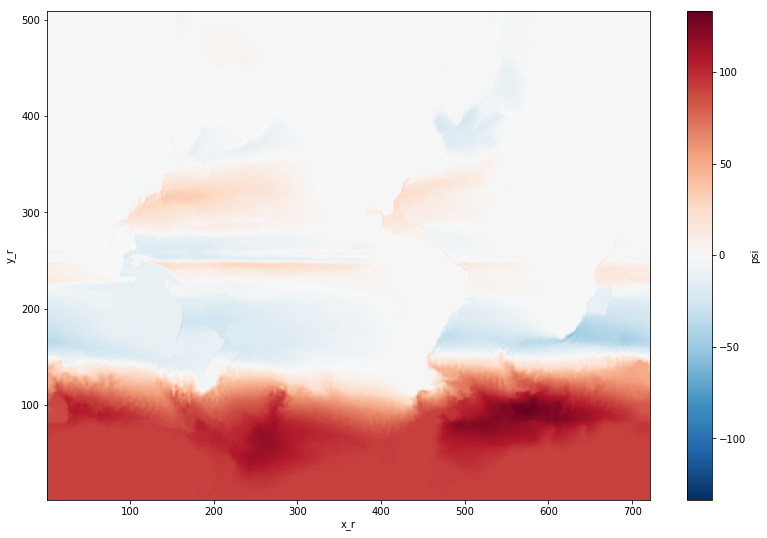

In [12]:
psi_mean.plot(size=9);

In [13]:
%%time
%memit speed_max = calculate_speed(ds_xorca).max(dim=["t", "z_c"]).compute()

peak memory: 807.38 MiB, increment: 446.21 MiB
CPU times: user 2min 21s, sys: 4.24 s, total: 2min 25s
Wall time: 3min 47s


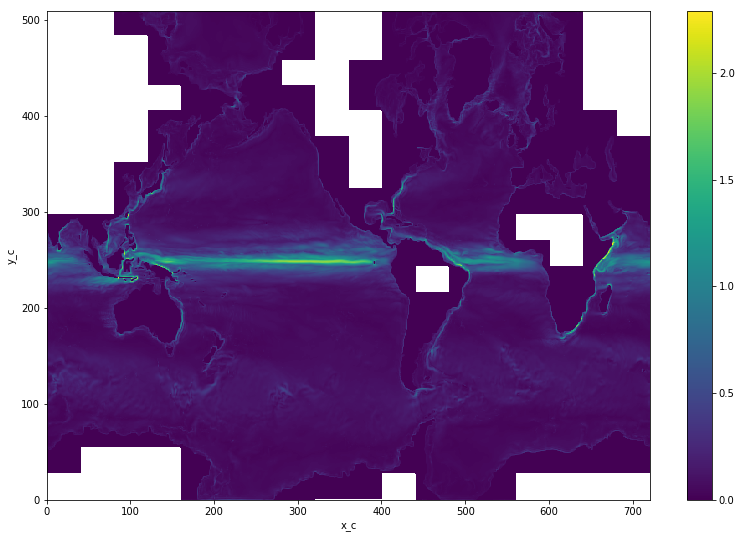

In [14]:
speed_max.plot(size=9);

In [15]:
%%time
%memit amoc_mean = calculate_moc(ds_xorca, region="atl").mean("t").compute()

peak memory: 784.00 MiB, increment: 0.18 MiB
CPU times: user 1min 29s, sys: 4.67 s, total: 1min 34s
Wall time: 3min


In [16]:
%%time
%memit amoc_std = calculate_moc(ds_xorca, region="atl").std("t").compute();

peak memory: 783.25 MiB, increment: 0.00 MiB
CPU times: user 1min 31s, sys: 4.76 s, total: 1min 36s
Wall time: 3min 7s


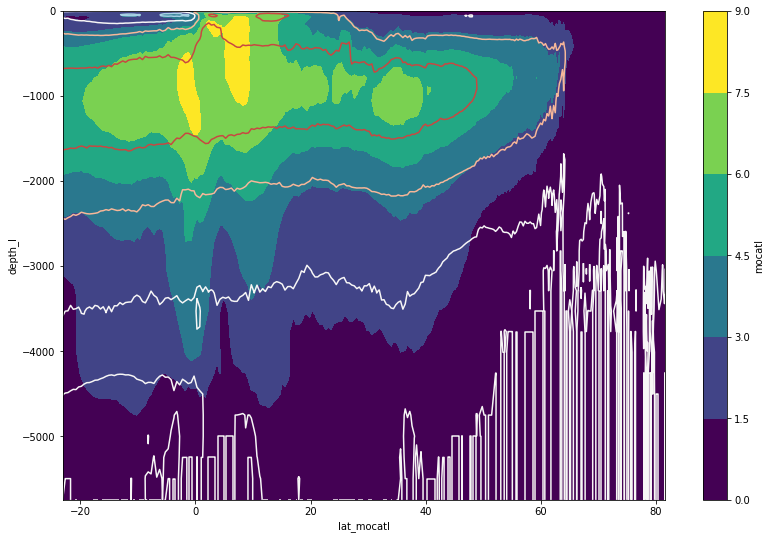

In [17]:
amoc_std.sortby("lat_mocatl").isel(y_r=slice(200, None)).plot.contourf("lat_mocatl", "depth_l", size=9);
amoc_mean.sortby("lat_mocatl").isel(y_r=slice(200, None)).plot.contour("lat_mocatl", "depth_l");